<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/rnn/rnn_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

In [1]:
import numpy as np

from numpy.random import randint
from collections import OrderedDict
from torch.utils import data

np.random.seed(42)

## Representing text as tokens

Let's define our dataset samples $x \in \mathrm{R}^d$, where $d$ is the feature space dimension.

With time sequences our data can be represented as $x \in \mathrm{R}^{t \, \times \, d}$, where $t$ is the sequence length. 
This emphasises sequence dependence and that the samples along the sequence are not independent and identically distributed (i.i.d.).
We will model functions as $\mathrm{R}^{t \, \times \, d} \rightarrow \mathrm{R}^c$, where $c$ is the amount of classes in the output.

There are several ways to represent sequences. With text, the challenge is how to represent a word as a feature vector in $d$ dimensions, as we are required to represent text with decimal numbers in order to apply neural networks to it.

Initially, we will use a simple one-hot encoding but for categorical variables that can take on many values (e.g. words in the English language).

### One-hot encoding over vocabulary

One way to represent a fixed amount of words is by making a one-hot encoded vector, which consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify each word.

| vocabulary    | one-hot encoded vector   |
| ------------- |--------------------------|
| Paris         | $= [1, 0, 0, \ldots, 0]$ |
| Rome          | $= [0, 1, 0, \ldots, 0]$ |
| Copenhagen    | $= [0, 0, 1, \ldots, 0]$ |

Representing a large vocabulary with one-hot encodings often becomes inefficient because of the size of each sparse vector.
To overcome this challenge it is common practice to truncate the vocabulary to contain the $k$ most used words and represent the rest with a special symbol, $\mathtt{UNK}$, to define unknown/unimportant words.
This often causes entities such as names to be represented with $\mathtt{UNK}$ because they are rare.

Consider the following text
> I love the corny jokes in Spielberg's new movie.

where an example result would be similar to
> I love the corny jokes in $\mathtt{UNK}$'s new movie.

### Generating a dataset

We generate sequences of the form:

`a b EOS`,

`a a b b EOS`,

`a a a a a b b b b b EOS`

where `EOS` is a special character denoting the end of a sequence. The task is to predict the next token $t_n$, i.e. `a`, `b`, `EOS` or the unknown token `UNK` given a sequence of tokens $\{ t_{1}, t_{2}, \dots , t_{n-1}\}$, and we are to process sequences in a sequential manner. As such, the network will need to learn that e.g. 5 `b`s and an `EOS` token will be preceded by 5 `a`s.

In [2]:
CHARS = ['a', 'b']
UNKNOWN = 'U'
EOS = 'E'
VOCAB = [UNKNOWN, EOS] + CHARS
VOCAB_SIZE = len(VOCAB)
NUM_SENTENCES = 2**8
HIDDEN_SIZE = 50
P_TRAIN = int(NUM_SENTENCES * 0.8)
P_VAL = int(NUM_SENTENCES * 0.1)
P_TEST = int(NUM_SENTENCES * 0.1)

In [3]:
def generate_dataset(num_sequences):
  """
  Generated a number of sequences as out dataset.
  """
  generate_random_token = lambda num_tokens: (
      ''.join([c * num_tokens for c in CHARS]) + EOS
  )
  return [generate_random_token(randint(1, 12)) for _ in range(num_sequences)]

In [4]:
sequences = generate_dataset(NUM_SENTENCES)
sequences[:5]

['aaaaaaabbbbbbbE',
 'aaaabbbbE',
 'aaaaaaaaaaabbbbbbbbbbbE',
 'aaaaaaaabbbbbbbbE',
 'aaaaabbbbbE']

## Representing tokens as indices

To build a one-hot encoding, we need to assign each possible word in our vocabulary an index. We do that by creating two dictionaries: one that allows us to go from a given word to its corresponding index in our vocabulary, and one for the reverse direction. Let's call them `word_to_idx` and `idx_to_word`. The keyword `vocab_size` specifies the maximum size of our vocabulary. If we try to access a word that does not exist in our vocabulary, it is automatically replaced by the `UNK` token or its corresponding index.

In [5]:
word_to_idx = OrderedDict((word, index) for index, word in enumerate(VOCAB)) 
idx_to_word = OrderedDict((index, word) for index, word in enumerate(VOCAB))

## Partitioning the dataset

In [6]:
class Dataset(data.Dataset):
  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, index):
    X = self.inputs[index]
    y = self.targets[index]
    return X, y

In [7]:
inputs = [sequences[i][:-1] for i in range(len(sequences))]
targets = [sequences[i][1:] for i in range(len(sequences))]
train_set = Dataset(inputs[:P_TRAIN], targets[:P_TRAIN])
val_set = Dataset(inputs[P_TRAIN:P_TRAIN + P_VAL], targets[P_TRAIN:P_TRAIN + P_VAL])
test_set = Dataset(inputs[-P_TEST:], targets[-P_TEST:])

print(f'We have {len(train_set)} samples in the training set.')
print(f'We have {len(val_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 204 samples in the training set.
We have 25 samples in the validation set.
We have 25 samples in the test set.


## One-hot encodings
We now create a simple function that returns the one-hot encoded representation of a given index of a word in our vocabulary. Notice that the shape of the one-hot encoding is equal to the entire vocabulary (which can be huge!). Additionally, we define a function to automatically one-hot encode a sentence.

In [8]:
def one_hot_encode(idx):
    '''
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    '''
    # Initialize the encoded array
    one_hot = np.zeros(VOCAB_SIZE)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence):
    '''
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    '''
    # Encode each word in the sentence
    encoding = np.array(
        [one_hot_encode(word_to_idx[word]) for word in sequence]
    )

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding

test_word = one_hot_encode(word_to_idx['a'])
print(f'One-hot encoding of "a" has shape {test_word.shape} -> {test_word}')

test_sent = one_hot_encode_sequence(['a', 'b'])
print(f'One-hot encoding of "a b" has shape {test_sent.shape} -> {test_sent}')

One-hot encoding of "a" has shape (4,) -> [0. 0. 1. 0.]
One-hot encoding of "a b" has shape (2, 4, 1) -> [[[0.]
  [0.]
  [1.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [1.]]]


# Recurrent Neural Networks (RNN)
___

A RNN performs its computations in a cyclic manner, where the same computation is applied to every sample of a given sequence.
The idea is that the network should be able to use the previous computations as some form of memory and apply this to future computations.

![rnn-unroll image](https://github.com/martin-fabbri/colab-notebooks/raw/master/rnn/images/rnn-folded-unfolded.png)


where:

- $X$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ is a non-linear activation function, e.g. $\mathrm{tanh}$.
- $o_t = W\,{h_t}$

When we are doing language modelling using a cross-entropy loss, we additionally apply the softmax function to the output $o_{t}$:

- $\hat{y}_t = \mathrm{softmax}(o_{t})$


### Backpropagation through time

We define a loss function

- $E = \sum_t E_t  = \sum_t E_t(y_t ,\hat{y}_t ) \ , $

where $E_t(y_t ,\hat{y}_t )$ is the cross-entropy function.

## Implementation

We will implement the forward pass, backward pass, optimization and training loop for an RNN in numpy so that you can get familiar with the recurrent nature of RNNs. Later, we will go back to PyTorch and appreciate how convenient the implementation becomes!

In [9]:
def init_orthogonal(param):
    """
    Initializes weight parameters orthogonally.
    This is a common initiailization for recurrent neural networks.
    
    Refer to this paper for an explanation of this initialization:
    https://arxiv.org/abs/1312.6120
    """
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    
    new_param = np.random.randn(rows, cols)
    
    if rows < cols:
        new_param = new_param.T
    
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param


def init_rnn(hidden_size, vocab_size):
    """
    Initializes our recurrent neural network.
    
    Args:
     `hidden_size`: the dimensions of the hidden state
     `vocab_size`: the dimensions of our vocabulary
    """
    # Weight matrix (input to hidden state)
    # YOUR CODE HERE!
    U = np.zeros((hidden_size, vocab_size))

    # Weight matrix (recurrent computation)
    # YOUR CODE HERE!
    V = np.zeros((hidden_size, hidden_size))

    # Weight matrix (hidden state to output)
    # YOUR CODE HERE!
    W = np.zeros((vocab_size, hidden_size))

    # Bias (hidden state)
    # YOUR CODE HERE!
    b_hidden = np.zeros((hidden_size, 1))

    # Bias (output)
    # YOUR CODE HERE!
    b_out = np.zeros((vocab_size, 1))
    
    # Initialize weights
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)
    
    # Return parameters as a tuple
    return U, V, W, b_hidden, b_out


params = init_rnn(hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE)
print('U:', params[0].shape)
print('V:', params[1].shape)
print('W:', params[2].shape)
print('b_hidden:', params[3].shape)
print('b_out:', params[4].shape)

for param in params:
    assert param.ndim == 2, \
        'all parameters should be 2-dimensional '\
        '(hint: a dimension can simply have size 1)'

U: (50, 4)
V: (50, 50)
W: (4, 50)
b_hidden: (50, 1)
b_out: (4, 1)


#### Sigmoid activation
$\sigma(x) = \frac{1}{1 + e^{-x}}$

In [10]:
def sigmoid(x, derivative=False):
    '''
    Computes the element-wise sigmoid activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    '''
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return f * (1 - f)
    else: # Return the forward pass of the function at x
        return f

#### Hyperbolic Tangent activation

$\tanh{x} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$

In [11]:
def tanh(x, derivative=False):
    """
    Computes the element-wise tanh activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return 1-f**2
    else: # Return the forward pass of the function at x
        return f

#### Softmax

$\mathrm{softmax}(x) = \frac{e^{x_{i}}}{\sum_{j=1}^{K} e^{x_{j}}} \text { for } i=1, \ldots, K \text { and } \mathbf{x}=\left(x_{1}, \ldots, x_{K}\right) \in \mathbb{R}^{K}$

In [12]:
def softmax(x, derivative=False):
    """
    Computes the softmax for an array x.
    
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        pass # We will not need this one
    else: # Return the forward pass of the function at x
        return f

### Implement the forward 

Now that we have all the definitions in place, we can start to implement a forward pass.

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ is a non-linear activation function, e.g. $\mathrm{tanh}$.
- $o_t = W\,{h_t}$
- $\hat{y}_t = \mathrm{softmax}(o_{t})$

In [13]:
def forward_pass(inputs, hidden_state, params, activation_func=tanh):
    """
    Computes the forward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `hidden_state`: an already initialized hidden state
     `params`: the parameters of the RNN
    """
    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params
    
    # Create a list to store outputs and hidden states
    outputs, hidden_states = [], []
    
    # For each element in input sequence
    for t in range(len(inputs)):

        # Compute new hidden state
        # YOUR CODE HERE!
        hidden_state = activation_func(
            np.dot(U, inputs[t]) + np.dot(V, hidden_state) + b_hidden
        )

        # Compute output
        # YOUR CODE HERE!
        out = softmax(np.dot(W, hidden_state) + b_out)
        
        # Save results and continue
        outputs.append(out)
        hidden_states.append(hidden_state.copy())
    
    return outputs, hidden_states


# Get first sequence in training set
test_input_sequence, test_target_sequence = train_set[0]

# One-hot encode input and target sequence
test_input = one_hot_encode_sequence(test_input_sequence)
test_target = one_hot_encode_sequence(test_target_sequence)

# Initialize hidden state as zeros
hidden_state = np.zeros((HIDDEN_SIZE, 1))

# Now let's try out our new function
outputs, hidden_states = forward_pass(test_input, hidden_state, params)

print('Input sequence:')
print(test_input_sequence)

# print('\nTarget sequence:')
# print(test_target_sequence)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

Input sequence:
aaaaaaabbbbbbb

Predicted sequence:
['E', 'b', 'a', 'U', 'a', 'a', 'a', 'b', 'a', 'b', 'b', 'b', 'b', 'b']


___
U: (50, 4)   V: (50, 50)   W: (4, 50)   b_hidden: (50, 1)   b_out: (4, 1)
___


## Backward pass

Implement the missing code in the backward pass code given below using a cross-entropy loss and $\tanh{x}$ as non-linear activation function $f$.

To complete the implementation, we need to compute the partial derivatives
$
\frac{\partial E}{\partial W},~\frac{\partial E}{\partial U},~\frac{\partial E}{\partial V}
$. 
We repeat the definition of the RNN forward pass from above:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = W\,{h_t}$
- $\hat{y}_t = \mathrm{softmax}(o_{t})$

where
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output), and
- $h$ is the hidden state (the network's memory) for a given time step.

Recall though, that RNNs are recurrent and the weights $W,~U,~V$ are shared across time, i.e. we do not have separate weights for each time step. Therefore, to compute e.g. the partial derivative $\frac{\partial E}{\partial W}$, we need to 1) sum up across time, and 2) apply the chain rule:

$$\frac{\partial E}{\partial W} = \sum_{t} \frac{\partial E}{\partial o_{t}} \frac{\partial o_{t}}{\partial W}\,.$$
To compute$\frac{\partial o_{t}}{\partial W}$ we use the definition of $o_t$ above.
From week 1 (exercise i) we have that
$$\delta_{o,t} \equiv \frac{\partial E}{\partial o_{t}} = \frac{\partial E_t}{\partial o_{t}} = \hat{y}_{t} - y_{t}\,,$$
where $\hat{y}_{t}$ is a softmax distribution over model outputs $o_{t}$ at time $t$, and $y_{t}$ is the target label at time $t$. In the above code, this corresponds to
```
d_o = outputs[t].copy()
d_o[np.argmax(targets[t])] -= 1
```
where `outputs[t]` is the output $\hat{y}_{t}$, and `targets[t]` is a one-hot encoded target.

To compute $\frac{\partial E}{\partial U}$ and $\frac{\partial E}{\partial V}$ we again sum over time and use the chain rule:
$$
\frac{\partial E}{\partial U} = \sum_{t} \frac{\partial E}{\partial h_{t}} \frac{\partial h_{t}}{\partial U} \ . 
$$
This leads us to introduce
$$
\delta_{h,t} \equiv \frac{\partial E}{\partial h_{t}} \ .
$$
The backpropagation through time recursion is derived by realising that a variation of $h_t$ affects 1) the loss at time step $t$ through the feed-forward connection to the output and 2) the future losses through the $h_{t+1}$ dependence of $h_t$. Mathematically, we write this through the chain rule:

$$
\delta_{h,t} \equiv \frac{\partial E}{\partial h_{t}} =  \frac{\partial E}{\partial o_{t}} \frac{\partial o_t}{\partial h_{t}} + \frac{\partial E}{\partial h_{t+1}}
\frac{\partial h_{t+1}}{\partial h_{t}} = \delta_{o,t} \frac{\partial o_t}{\partial h_{t}} + \delta_{h,t+1}
\frac{\partial h_{t+1}}{\partial h_{t}} \ . 
$$

Like above we can compute $\frac{\partial h_{t+1}}{\partial h_{t}}$ using the definition of the network (shifted one time step). In the code the intermediate steps to compute the $\delta$ recursions have been precomputed for you. 





In [14]:
params[2].shape

(4, 50)

In [15]:
def clip_gradient_norm(grads, max_norm=0.25):
    """
    Clips gradients to have a maximum norm of `max_norm`.
    This is to prevent the exploding gradients problem.
    """ 
    # Set the maximum of the norm to be of type float
    max_norm = float(max_norm)
    total_norm = 0
    
    # Calculate the L2 norm squared for each gradient and add them to the total norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    
    total_norm = np.sqrt(total_norm)
    
    # Calculate clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)
    
    # If the total norm is larger than the maximum allowable norm, then clip the gradient
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    
    return grads

In [16]:
def backward_pass(inputs, outputs, hidden_states, targets, params):
    """
    Computes the backward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `outputs`: sequence of outputs from the forward pass
     `hidden_states`: sequence of hidden_states from the forward pass
     `targets`: sequence of targets
     `params`: the parameters of the RNN
    """
    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params
    
    # Initialize gradients as zero
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
    
    # Keep track of hidden state derivative and loss
    d_h_next = np.zeros_like(hidden_states[0])
    loss = 0
    
    # For each element in output sequence
    # NB: We iterate backwards s.t. t = N, N-1, ... 1, 0
    for t in reversed(range(len(outputs))):

        # Compute the cross-entropy loss E (as a scalar)
        # When taking logarithms, it's a good idea to add a small constant (e.g. 1e-9)
        # YOUR CODE HERE!
        loss += -np.mean(targets[t] * np.log(outputs[t] + 1e-9))
        
        # Backpropagate into output o (derivative of cross-entropy)
        # If you're confused about this step, see this link for an explanation:
        # http://cs231n.github.io/neural-networks-case-study/#grad
        d_o = outputs[t].copy()
        d_o[np.argmax(targets[t])] -= 1
        
        # Backpropagate into weights W
        # YOUR CODE HERE!
        d_W += np.dot(d_o, hidden_states[t].T)
        d_b_out += d_o
        
        # Backpropagate into hidden state h
        d_h = np.dot(W.T, d_o) + d_h_next
        
        # Backpropagate through non-linearity f
        # (we assume tanh is used here)
        d_f = (1 - hidden_states[t]**2) * d_h
        d_b_hidden += d_f
        
        # Backpropagate into weights U
        # YOUR CODE HERE!
        d_U += np.dot(d_f, inputs[t].T)
        
        # Backpropagate into weights V
        # YOUR CODE HERE!
        d_V += np.dot(d_f, hidden_states[t-1].T)
        d_h_next = np.dot(V.T, d_f)
    
    # Pack gradients
    grads = d_U, d_V, d_W, d_b_hidden, d_b_out    
    
    # Clip gradients
    grads = clip_gradient_norm(grads)
    
    return loss, grads


loss, grads = backward_pass(test_input, outputs, hidden_states, test_target, params)

print('We get a loss of:')
print(loss)

We get a loss of:
4.343361021444801


### Optimization

Now that we can do forward passes and compute gradients with backpropagation, we're ready to train our network. For that we will need an optimizer. A common and easy to implement optimization method is stochastic gradient descent (SGD), which has the update rule: $\theta_{n+1} = \theta_{n} - \eta \frac{\partial E}{\partial \theta_{n}}$, where $\eta$ is the learning rate and $E$ is our cost function. This is essentially what's going on behind the scenes when you run `optimizer.step()` in PyTorch using the SGD optimizer. If you want to learn more about optimization in a deep learning context, [this is a great starting point](https://arxiv.org/abs/1609.04747).

In [17]:
def update_parameters(params, grads, lr=1e-3):
    # Take a step
    for param, grad in zip(params, grads):
        param -= lr * grad
    
    return params

### Training Loop

We need to define a full training loop with a forward pass, backward pass, optimization step and validation. Training will take approximately 5 minutes, so you might want to read on while the notebook is running.

Epoch 0, training loss: 4.533073143254339, validation loss: 4.803672524872286
Epoch 100, training loss: 1.4988155705003372, validation loss: 1.582402058607385
Epoch 200, training loss: 1.0702117369140383, validation loss: 1.140875855944345
Epoch 300, training loss: 1.0195988311873245, validation loss: 1.1383936781951538
Epoch 400, training loss: 1.0206038315120267, validation loss: 1.1715226369805374
Epoch 500, training loss: 1.0212138262451527, validation loss: 1.197553568370234
Epoch 600, training loss: 1.0522706610511043, validation loss: 1.2305981092291913
Epoch 700, training loss: 1.2041279011896884, validation loss: 1.3795271029694354
Epoch 800, training loss: 1.5784430455774539, validation loss: 1.7381703010302614
Epoch 900, training loss: 1.967908911383222, validation loss: 2.2458325199415303
Input sentence:
aaaabbbb

Target sequence:
aaabbbbE

Predicted sequence:
['b', 'b', 'b', 'a', 'b', 'b', 'b', 'E']


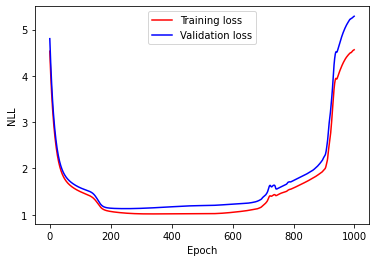

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# Hyper-parameters
num_epochs = 1000

# Initialize a new network
params = init_rnn(hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE)

# Initialize hidden state as zeros
hidden_state = np.zeros((HIDDEN_SIZE, 1))

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
     # For each sentence in validation set
    for inputs, targets in val_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs)
        targets_one_hot = one_hot_encode_sequence(targets)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        # YOUR CODE HERE!
        outputs, hidden_states = forward_pass(
            inputs_one_hot,
            hidden_state,
            params
        )

        # Backward pass
        # YOUR CODE HERE!
        loss, _ = backward_pass(
            inputs_one_hot,
            outputs,
            hidden_states,
            targets_one_hot,
            params
        )
        
        # Update loss
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for inputs, targets in train_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs)
        targets_one_hot = one_hot_encode_sequence(targets)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        # YOUR CODE HERE!
        outputs, hidden_states = forward_pass(
            inputs_one_hot,
            hidden_state,
            params
        )

        # Backward pass
        # YOUR CODE HERE!
        loss, grads = backward_pass(
            inputs_one_hot,
            outputs,
            hidden_states,
            targets_one_hot,
            params
        )
        
        if np.isnan(loss):
            raise ValueError('Gradients have vanished/exploded!')
        
        # Update parameters
        # YOUR CODE HERE!
        params = update_parameters(params, grads, lr=1e-3)
        
        # Update loss
        epoch_training_loss += loss
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(train_set))
    validation_loss.append(epoch_validation_loss/len(val_set))

    # Print loss every 100 epochs
    if i % 100 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs)
targets_one_hot = one_hot_encode_sequence(targets)

# Initialize hidden state as zeros
hidden_state = np.zeros((HIDDEN_SIZE, 1))

# Forward pass
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()